# 03-2 이미지 분류 모델의 성능 최적화하기

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/hm-dl/blob/main/03-2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

## 가장 높은 성능을 내는 모델 - EfficientNet

### 새로운 활성화 함수 - 스위시

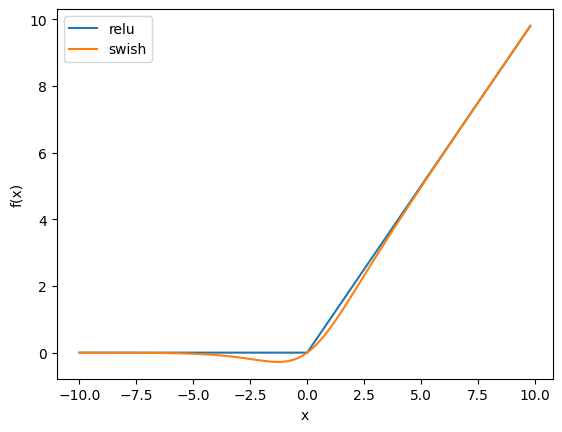

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit

x = np.arange(-10, 10, 0.2)

plt.plot(x, x.clip(0), label='relu')
plt.plot(x, x * expit(x), label='swish')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

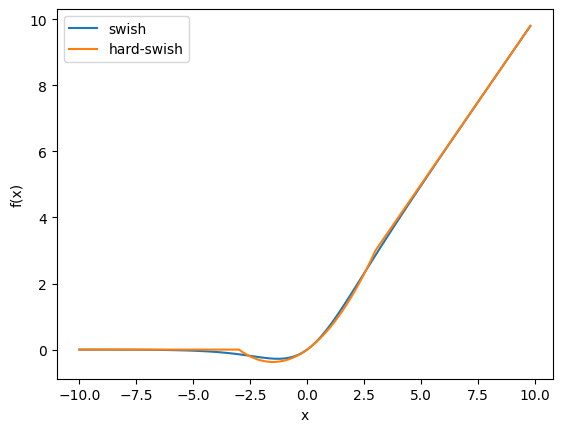

In [2]:
def relu6(x):
    return np.minimum(np.maximum(x, 0), 6)

x = np.arange(-10, 10, 0.2)

plt.plot(x, x * expit(x), label='swish')
plt.plot(x, x * relu6(x+3)/6, label='hard-swish')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show()

## EfficientNet 모델 만들기

### 역 잔차 블록 만들기

In [3]:
def inv_res_block(inputs, filters_out, kernel_size, strides, dropout_rate, expand_ratio):
    # 팽창 단계
    filters_in = inputs.shape[-1]
    filters = filters_in * expand_ratio
    if expand_ratio > 1:
        x = layers.Conv2D(filters, 1, padding='same', use_bias=False)(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('swish')(x)
    else:
        x = inputs

    # 깊이별 분리 합성곱
    if strides == 2:
        x = layers.ZeroPadding2D(padding=padding_size(x.shape, kernel_size))(x)
    x = layers.DepthwiseConv2D(kernel_size, strides=strides, use_bias=False,
                               padding='same' if strides == 1 else 'valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('swish')(x)

    # SE 블록
    se_input = x
    x = layers.GlobalAveragePooling2D(keepdims=True)(x)
    x = layers.Conv2D(int(filters_in * 0.25), 1, padding='same', activation='swish')(x)
    x = layers.Conv2D(filters, 1, padding='same', activation='sigmoid')(x)
    x = layers.Multiply()([se_input, x])

    # 출력 단계
    x = layers.Conv2D(filters_out, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    if strides == 1 and filters_in == filters_out:
        if dropout_rate > 0:
            x = layers.Dropout(dropout_rate, noise_shape=(None, 1, 1, 1))(x)
            x = layers.Add()([x, inputs])
    return x

In [4]:
def padding_size(input_size, kernel_size):
    # 입력 크기가 짝수이면 위쪽과 왼쪽 패딩을 하나 줄입니다.
    padding = kernel_size // 2
    if input_size[1] % 2 == 0:
        return ((padding - 1, padding),
                (padding - 1, padding))
    else:
        return padding

In [5]:
import math

def round_repeats(repeats, depth):
    """repeats * depth 보다 큰 정수를 반환합니다"""
    return int(math.ceil(repeats * depth))

def round_filters(filters, width):
    """filters * width 보다 크고 8의 배수가 되도록 만듭니다"""
    filters *= width
    new_filters = max(8, int(filters + 4) // 8 * 8)
    if new_filters < 0.9 * filters:
        new_filters += 8
    return int(new_filters)

### EfficientNet 모델 만들기

In [6]:
import keras
from keras import layers

In [7]:
width = 1.0
depth = 1.0
inputs = layers.Input(shape=(224, 224, 3))

x = layers.Rescaling(1.0 / 255.0)(inputs)
x = layers.Normalization()(x)
x = layers.Rescaling(1.0 / np.sqrt([0.229, 0.224, 0.225]))(x)
x = layers.ZeroPadding2D(padding=padding_size(x.shape, 3))(x)
x = layers.Conv2D(round_filters(32, width), 3, strides=2, padding='valid', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('swish')(x)

In [8]:
blocks_params = [
    {
        "kernel_size": 3,
        "repeats": 1,
        "filters_out": 16,
        "strides": 1
    },
    {
        "kernel_size": 3,
        "repeats": 2,
        "filters_out": 24,
        "strides": 2
    },
    {
        "kernel_size": 5,
        "repeats": 2,
        "filters_out": 40,
        "strides": 2
    },
    {
        "kernel_size": 3,
        "repeats": 3,
        "filters_out": 80,
        "strides": 2
    },
    {
        "kernel_size": 5,
        "repeats": 3,
        "filters_out": 112,
        "strides": 1
    },
    {
        "kernel_size": 5,
        "repeats": 4,
        "filters_out": 192,
        "strides": 2
    },
    {
        "kernel_size": 3,
        "repeats": 1,
        "filters_out": 320,
        "strides": 1
    },
]

In [9]:
filter_expand_ratio = 1
block_count = 0
total_blocks = float(sum(round_repeats(params["repeats"], depth) for params in blocks_params))
for params in blocks_params:
    # depth에 따라 블록의 입력과 출력 필터를 늘립니다.
    filters_out = round_filters(params['filters_out'], width)
    strides = params["strides"]
    for j in range(round_repeats(params["repeats"], depth)):
        # 반복의 첫 번째 블록을 제외한 나머지 블록은 스트라이드 1입니다.
        if j > 0:
            strides = 1
        dropout_rate = 0.2 * block_count / total_blocks
        x = inv_res_block(x, filters_out, params['kernel_size'],
                          strides, dropout_rate, filter_expand_ratio)
        block_count += 1
    filter_expand_ratio = 6

In [10]:
x = layers.Conv2D(round_filters(1280, width), 1, padding='same', use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('swish')(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1000, activation='softmax')(x)

model = keras.Model(inputs, outputs)

In [11]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │        864 │ zero_padding2d[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 112, 112,  │        288 │ activation[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        128 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1, 1, 32)  │          0 │ activation_1[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 1, 1, 8)   │        264 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 1, 1, 32)  │        288 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 112, 112,  │          0 │ activation_1[0][… │
│                     │ 32)               │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │        512 │ multiply[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │         64 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 5,330,571 (20.33 MB)

 Trainable params: 5,288,548 (20.17 MB)

 Non-trainable params: 42,023 (164.16 KB)

## EfficientNet 모델로 강아지 사진 분류하기

In [12]:
!gdown 1xGkTT3uwYt4myj6eJJeYtdEFgTi2Sj8C
!unzip cat-dog-images.zip

Downloading...
From: https://drive.google.com/uc?id=1xGkTT3uwYt4myj6eJJeYtdEFgTi2Sj8C
To: /content/cat-dog-images.zip
100% 182k/182k [00:00<00:00, 120MB/s]
Archive:  cat-dog-images.zip
   creating: images/
  inflating: images/dog.png          
  inflating: images/cat.png          


In [13]:
import numpy as np
from PIL import Image

dog_png = np.array(Image.open('images/dog.png'))

In [14]:
from keras.applications import efficientnet

efficientb0 = keras.applications.EfficientNetB0()
predictions = efficientb0.predict(dog_png[np.newaxis,:])
efficientnet.decode_predictions(predictions)

21834768/21834768 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


[[('n02099712', 'Labrador_retriever', np.float32(0.36829436)),
  ('n02104029', 'kuvasz', np.float32(0.19339839)),
  ('n02099601', 'golden_retriever', np.float32(0.06145825)),
  ('n02111500', 'Great_Pyrenees', np.float32(0.057796903)),
  ('n02095889', 'Sealyham_terrier', np.float32(0.017902784))]]